<img src="logo/pschitt_low.jpg" alt="pschitt logo" style="width: 200px;"/>
# pschitt! - A Python package for the modelling of atmoSpheric Showers and CHerenkov Imaging Terrestrial Telescopes

_**Thomas Vuillaume, LAPP ctapipe workshop, September 2017**_

In [1]:
import pschitt.geometry as geo
import numpy as np
import matplotlib.pyplot as plt
import pschitt.sky_objects as sky
import pschitt.camera_image as ci
import pschitt.hillas as hillas
import pschitt.vizualisation as viz
from importlib import reload
import math
%matplotlib inline
np.set_printoptions(precision=2)

# Create a shower

In [2]:
shower = sky.shower()

shower.impact_point = np.array([80,60,0])

#shower direction
shower.alt = math.radians(80)
shower.az = math.radians(90)

#shower parameters
shower_top = 12000
shower_length = 8000
shower_width = 100

shower.number_of_particles = int(1e4)

In [4]:
shower.gaussian_ellipsoide(shower_top, shower_length, shower_width)

# Create a telescope array

In [5]:
#pointing direction
talt = math.radians(81)
taz = math.radians(89)

In [6]:
tel_normal = geo.altaz_to_normal(talt,taz)
tel1 = geo.Telescope([200,200,0],tel_normal)
tel2 = geo.Telescope([-200,200,0],tel_normal)
tel3 = geo.Telescope([-200,-200,0],tel_normal)
tel4 = geo.Telescope([200,-200,0],tel_normal)
tel5 = geo.Telescope([0,0,0],tel_normal)

alltel = [tel1, tel2, tel3, tel4, tel5]

# Image it

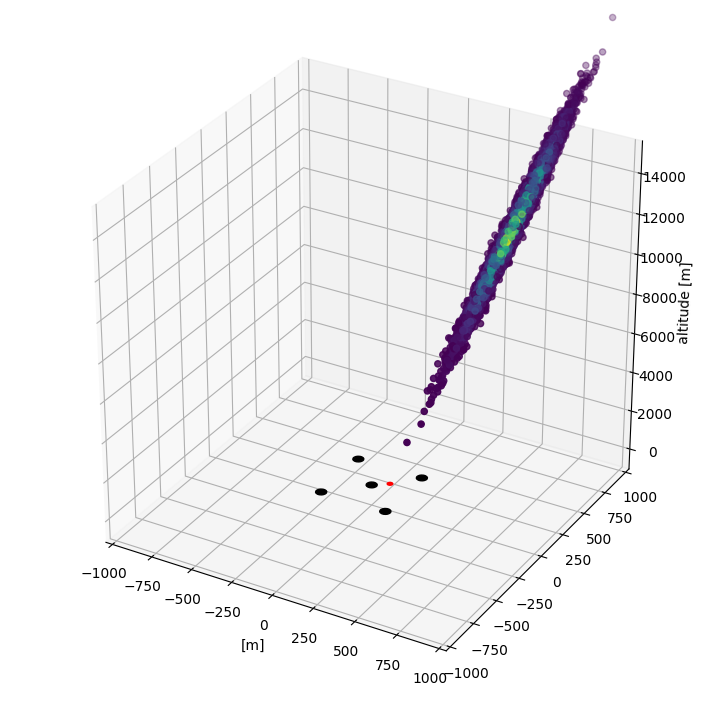

In [7]:
viz.plot_shower3d(shower, alltel, density_color=True, figsize=(9,9))

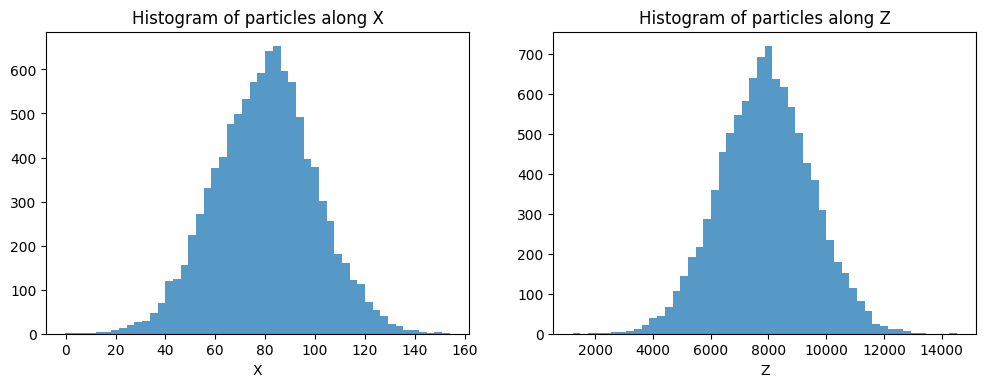

In [8]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].hist(shower.array[:,0], bins=50, alpha=0.75);
axs[0].set_xlabel("X")
axs[0].set_title("Histogram of particles along X")
axs[1].hist(shower.array[:,2], bins=50, alpha=0.75);
axs[1].set_xlabel("Z")
axs[1].set_title("Histogram of particles along Z")

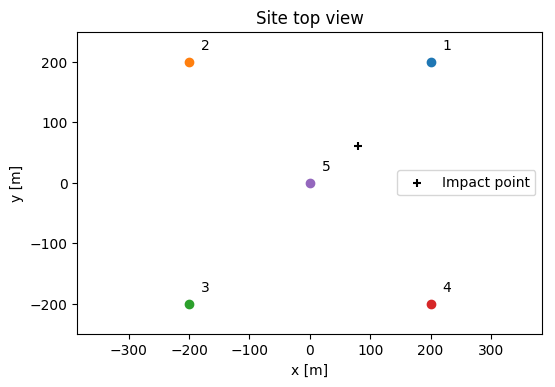

In [9]:
plt.scatter(shower.impact_point[0], shower.impact_point[1], color='black', label='Impact point', marker="+")

viz.plot_array(alltel)
plt.axis('equal')
plt.ylim(-250,250)
plt.title("Site top view")

# Now we can image the shower with the telescope array

In [10]:
ci.array_shower_imaging(shower, alltel, 0)

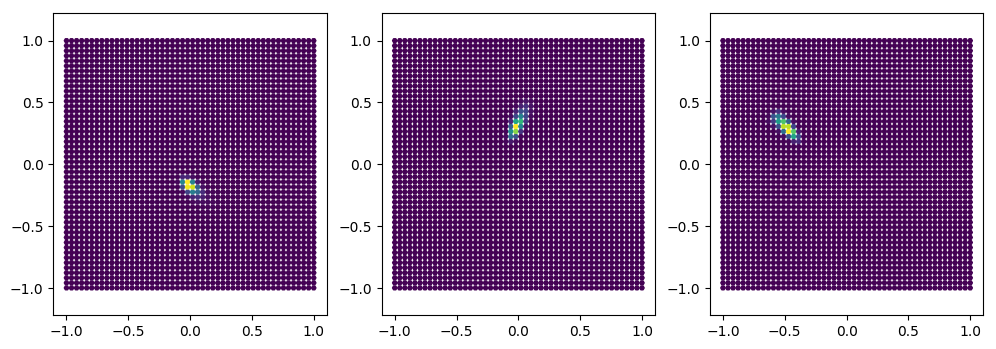

In [11]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
for i in range(3):
    axs[i].scatter(alltel[i].pixel_tab[:,0], alltel[i].pixel_tab[:,1], c = alltel[i].signal_hist, marker='H', s=10);
    axs[i].axis('equal');

Number of triggered telescopes =  5


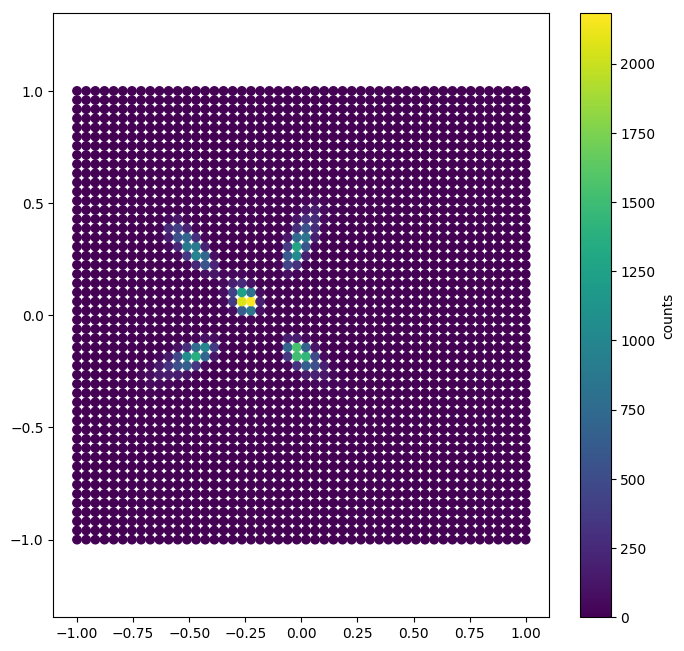

In [12]:
plt.figure(figsize=(8,8))
trigger_intensity = 20.
HP, triggered_telescopes = hillas.array_hillas_parameters(alltel, trigger_intensity)
print("Number of triggered telescopes = ", len(triggered_telescopes))
viz.display_stacked_cameras(triggered_telescopes)

# From here, one can compute the Hillas parameters and check the reconstruction

In [13]:
if len(triggered_telescopes)>1:
    pa = hillas.impact_parameter_average(triggered_telescopes, HP)
    p = hillas.impact_parameter_ponderated(triggered_telescopes, HP)

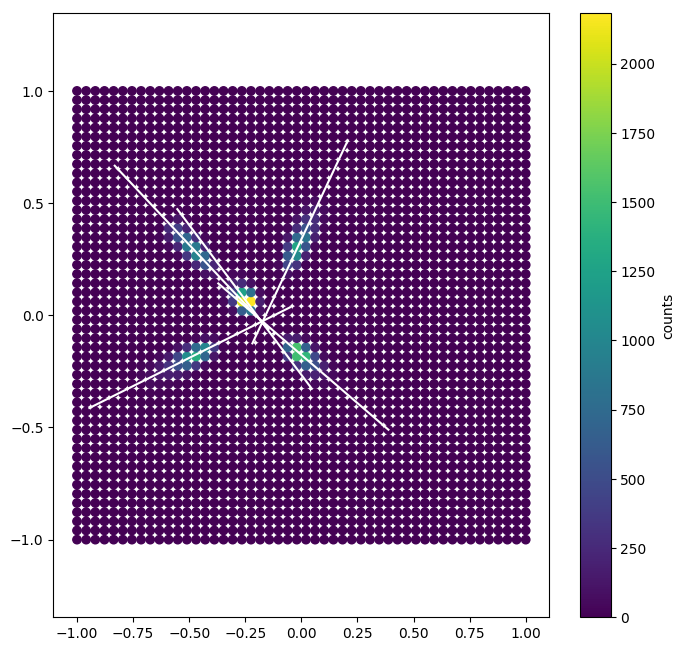

In [14]:
plt.figure(figsize=(8,8))
viz.display_stacked_cameras(alltel)
x = np.linspace(-0.5, 0.5)
for tel, hp in zip(triggered_telescopes, HP):
    plt.plot(hp[1] + x*np.cos(hp[7] + math.pi/2.), hp[2] + x*np.sin(hp[7] + math.pi/2.), color="white")
    plt.axis('equal')

In [16]:
def plot_site_reconstruction_impact(HP):
    x = np.linspace(-300,300)
    HP = np.array(HP)

    plt.figure(figsize=(8,8))

    plt.axis('equal')
    for tel in triggered_telescopes:
        plt.scatter(tel.mirror_center[0], tel.mirror_center[1])

    for (tel, hp) in zip(triggered_telescopes, HP):
        alt = talt
        az = taz
        psi = hp[7] + np.pi/2.
        n = [
        np.sin(alt)**2 * np.cos(az) * np.cos(psi) - np.sin(alt)*np.sin(az) * np.sin(psi) + np.cos(alt)**2 * np.sin(az)*np.cos(psi),
        np.sin(alt)**2 * np.sin(az) * np.cos(psi) + np.sin(alt)*np.cos(az) * np.sin(psi) - np.cos(alt)**2 * np.cos(az)*np.cos(psi)
        ]
        plt.plot(x*n[0] + tel.mirror_center[0], x*n[1] + tel.mirror_center[1]);

    plt.scatter(shower.impact_point[0], shower.impact_point[1], color='black', label='Impact point', marker='X', s=80)

    plt.axis('equal')
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    plt.legend()

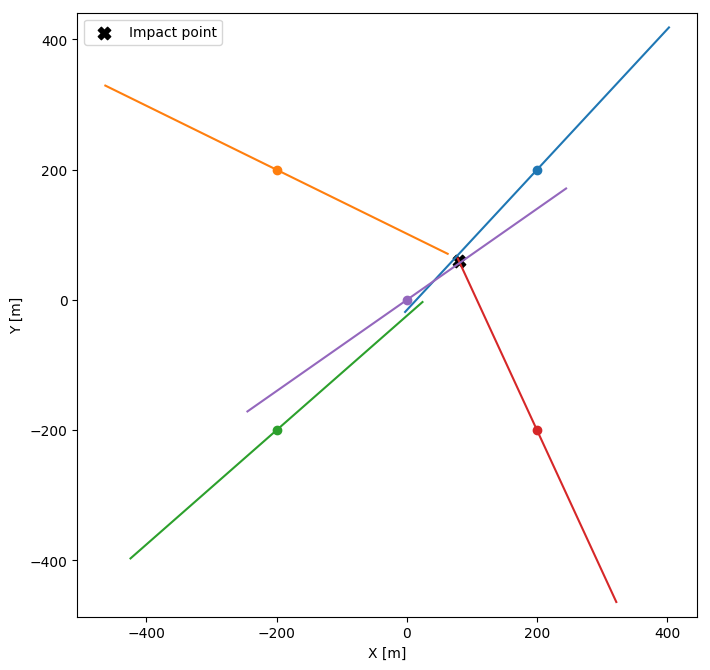

In [17]:
plot_site_reconstruction_impact(HP)

In [18]:
if len(triggered_telescopes)>1:
    print("Real impact parameter : ", shower.impact_point)
    print("Weigthed average reconstruction point = %s \tError = %.2fm" % (np.array(p), math.sqrt(((shower.impact_point-p)**2).sum())))

Real impact parameter :  [80 60  0]
Weigthed average reconstruction point = [ 57.06  40.89   0.  ] 	Error = 29.86m


## Thank you